In [1]:
from pandas import read_csv
from datetime import datetime
from matplotlib import pyplot

## Data Cleaning

In [2]:
# load data
def parse(x):
    return datetime.strptime(x, '%Y %m %d %H')

dataset = read_csv('raw.csv',  parse_dates = [['year', 'month', 'day', 'hour']], index_col=0, date_parser=parse)

# drop "No" column
dataset.drop('No', axis=1, inplace=True)

# manually specify column names
dataset.columns = ['pollution', 'dew', 'temp', 'press', 'wnd_dir', 'wnd_spd', 'snow', 'rain']
dataset.index.name = 'date'

# mark all NA values with 0
dataset['pollution'].fillna(0, inplace=True)

# drop the first 24 hours
dataset = dataset[24:]

# summarize first 5 rows
print(dataset.head(5))

# save to file
dataset.to_csv('pollution.csv')

                     pollution  dew  temp   press wnd_dir  wnd_spd  snow  rain
date                                                                          
2010-01-02 00:00:00      129.0  -16  -4.0  1020.0      SE     1.79     0     0
2010-01-02 01:00:00      148.0  -15  -4.0  1020.0      SE     2.68     0     0
2010-01-02 02:00:00      159.0  -11  -5.0  1021.0      SE     3.57     0     0
2010-01-02 03:00:00      181.0   -7  -5.0  1022.0      SE     5.36     1     0
2010-01-02 04:00:00      138.0   -7  -5.0  1022.0      SE     6.25     2     0


## Visualize Cleaned Data

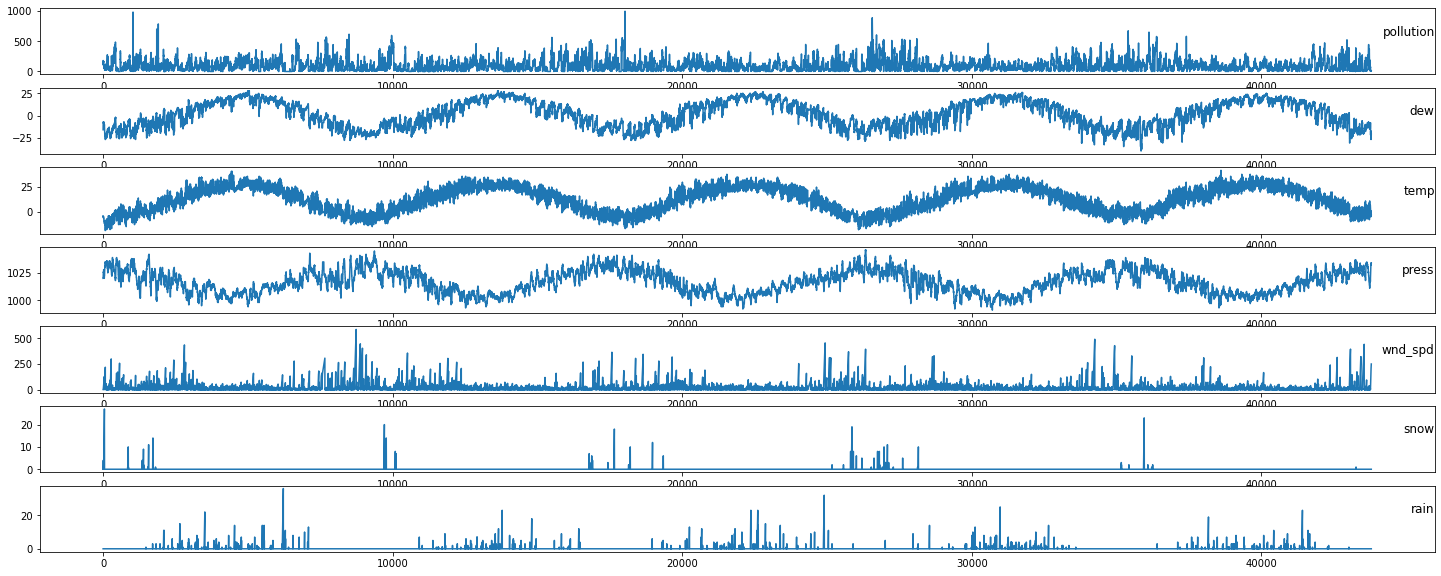

In [3]:
# load dataset
dataset = read_csv('pollution.csv', header=0, index_col=0)
values = dataset.values

# specify columns to plot
groups = [0, 1, 2, 3, 5, 6, 7]
i = 1
# plot each column
pyplot.figure(figsize=(25,10))
for group in groups:
    pyplot.subplot(len(groups), 1, i)
    pyplot.plot(values[:, group])
    pyplot.title(dataset.columns[group], y=0.5, loc='right')
    i += 1
pyplot.show()

## Transform dataset to supervised learning problem

In [4]:
from pandas import read_csv
from pandas import DataFrame
from pandas import concat
from sklearn.preprocessing import LabelEncoder, MinMaxScaler

In [5]:
# convert series to supervised learning
def series_to_supervised(data, n_in=1, n_out=1, dropnan=True):
    var_names = data.columns
    n_vars = len(var_names)
    df = DataFrame(data)
    cols, names = list(), list() # new column values, new columne names
    
    # input sequence (t-i, ... t-1)
    # timesteps before (e.g., n_in = 3, t-3, t-2, t-1)
    for i in range(n_in, 0, -1):
        cols.append(df.shift(i))
        names += list(
            map(lambda var_name: f'{var_name}(t-{i})', var_names)
        )
        
    # forecast sequence (t, t+1, ... t+n)
    # timesteps after (e.g., n_out = 3, t, t+1, t+2)
    for i in range(0, n_out):
        cols.append(df.shift(-i))
        if i == 0:
            names += list( map(lambda var_name: f'{var_name}(t)', var_names) )
        else:
            names += list( map(lambda var_name: f'{var_name}(t+{i})', var_names) )

    # put it all together
    agg = concat(cols, axis=1)
    agg.columns = names
    
    # drop rows with NaN values
    if dropnan:
        agg.dropna(inplace=True)

    return agg

# predict if polluted or not based on previous timesteps
def classify_pollution(pollution_value):
    if pollution_value >= 200:
        return 1.0
    else:
        return 0.0

In [6]:
# load dataset
dataset = read_csv('pollution.csv', header=0, index_col="date")

# classify pollution
dataset["is_polluted"] = dataset['pollution'].apply(lambda pollution: classify_pollution(pollution))

# integer encode direction
encoder = LabelEncoder()
dataset.wnd_dir = encoder.fit_transform(dataset.wnd_dir)
# reverse
# encoder.inverse_transform(dataset.wnd_dir.astype(int))

# ensure all data is float
dataset = dataset.astype('float32')

# frame as supervised learning
reframed = series_to_supervised(dataset, 1, 1)

In [ ]:
for index, value in enumerate(reframed.columns):
    print(f'{index}: {value}')

In [7]:
# drop columns we don't want to predict
reframed.drop(reframed.columns[[9,10,11,12,13,14,15,16]], axis=1, inplace=True)
display(reframed.head())
display(reframed.shape)

,pollution(t-1),dew(t-1),temp(t-1),press(t-1),wnd_dir(t-1),wnd_spd(t-1),snow(t-1),rain(t-1),is_polluted(t-1),is_polluted(t)
date,,,,,,,,,,
2010-01-02 01:00:00,129.0,-16.0,-4.0,1020.0,2.0,1.79,0.0,0.0,0.0,0.0
2010-01-02 02:00:00,148.0,-15.0,-4.0,1020.0,2.0,2.68,0.0,0.0,0.0,0.0
2010-01-02 03:00:00,159.0,-11.0,-5.0,1021.0,2.0,3.57,0.0,0.0,0.0,0.0
2010-01-02 04:00:00,181.0,-7.0,-5.0,1022.0,2.0,5.36,1.0,0.0,0.0,0.0
2010-01-02 05:00:00,138.0,-7.0,-5.0,1022.0,2.0,6.25,2.0,0.0,0.0,0.0


(43799, 10)

In [8]:
# normalize features
scaler = MinMaxScaler(feature_range=(0, 1))
reframed = DataFrame(
    scaler.fit_transform(reframed),
    columns = reframed.columns,
    index = reframed.index
)
reframed
# reverse
# DataFrame(
#     scaler.inverse_transform(scaled_dataset[scaled_dataset.columns]),
#     columns = scaled_dataset.columns,
#     index = scaled_dataset.index
# )

,pollution(t-1),dew(t-1),temp(t-1),press(t-1),wnd_dir(t-1),wnd_spd(t-1),snow(t-1),rain(t-1),is_polluted(t-1),is_polluted(t)
date,,,,,,,,,,
2010-01-02 01:00:00,0.129779,0.352941,0.245902,0.527273,0.666667,0.002290,0.000000,0.0,0.0,0.0
2010-01-02 02:00:00,0.148893,0.367647,0.245902,0.527273,0.666667,0.003811,0.000000,0.0,0.0,0.0
2010-01-02 03:00:00,0.159960,0.426471,0.229508,0.545454,0.666667,0.005332,0.000000,0.0,0.0,0.0
2010-01-02 04:00:00,0.182093,0.485294,0.229508,0.563637,0.666667,0.008391,0.037037,0.0,0.0,0.0
2010-01-02 05:00:00,0.138833,0.485294,0.229508,0.563637,0.666667,0.009912,0.074074,0.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...
2014-12-31 19:00:00,0.010060,0.264706,0.278689,0.763638,0.333333,0.385730,0.000000,0.0,0.0,0.0
2014-12-31 20:00:00,0.008048,0.250000,0.278689,0.781818,0.333333,0.395659,0.000000,0.0,0.0,0.0
2014-12-31 21:00:00,0.010060,0.264706,0.262295,0.781818,0.333333,0.405588,0.000000,0.0,0.0,0.0


## Prepare training and test dataset

In [9]:
import tensorflow as tf

In [61]:
# split into train & test sets
n_train_hours = 365 * 24 # 1 year in hours
train = reframed.iloc[:n_train_hours, :]
test = reframed.iloc[n_train_hours:, :]

print(f'Train: {train.shape}')
print(f'Test: {test.shape}')

Train: (8760, 10)
Test: (35039, 10)


In [62]:
target_column = "is_polluted(t)"

train_X, train_y = train.drop(target_column, axis=1), train[[target_column]]
test_X, test_y = test.drop(target_column, axis=1), test[[target_column]]
# or other way to write this, especially if there is a list of columns
# train_X, train_y = train.loc[:, train.columns != target_column], train[[target_column]]
# test_X, test_y = test.loc[:, test.columns != target_column], test.loc[:, [target_column]]

In [63]:
# reshape input to be 3D [samples, timesteps, features]
train_X = train_X.values.reshape(
    ( train_X.shape[0], 1, train_X.shape[1] )
)
# train_y = train_y.values.reshape(
#     ( train_y.shape[0] )
# )

test_X = test_X.values.reshape(
    ( test_X.shape[0], 1, test_X.shape[1] )
)
# test_y = test_y.values.reshape(
#     ( test_y.shape[0] )
# )
print(train_X.shape, train_y.shape, test_X.shape, test_y.shape)

(8760, 1, 9) (8760, 1) (35039, 1, 9) (35039, 1)


## Define LSTM model

In [13]:
from sklearn.metrics import mean_squared_error
from keras.models import Sequential
from keras.layers import Dense
from keras.layers import LSTM
from keras.losses import BinaryCrossentropy

In [14]:
def get_lstm_model():
    model = Sequential([
        LSTM(50,
            input_shape=(train_X.shape[1], train_X.shape[2])), # 1 time step w/ 8 features
        Dense(units=1, activation='sigmoid')
    ])
    model.compile(optimizer='adam',
                  loss=BinaryCrossentropy(from_logits=False),
                  metrics=['accuracy'])
    return model

## Fit LSTM model

In [15]:
model = get_lstm_model()
history = model.fit(train_X, train_y,
                    epochs = 10, batch_size = 72,
                    validation_data = ( test_X, test_y ),
                    verbose = 1, shuffle = False)

2022-06-07 08:07:11.469134: W tensorflow/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libcuda.so.1'; dlerror: libcuda.so.1: cannot open shared object file: No such file or directory
2022-06-07 08:07:11.469364: W tensorflow/stream_executor/cuda/cuda_driver.cc:269] failed call to cuInit: UNKNOWN ERROR (303)
2022-06-07 08:07:11.469436: I tensorflow/stream_executor/cuda/cuda_diagnostics.cc:156] kernel driver does not appear to be running on this host (4bdc45e2105a): /proc/driver/nvidia/version does not exist
2022-06-07 08:07:11.471198: I tensorflow/core/platform/cpu_feature_guard.cc:142] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.
2022-06-07 08:07:11.983863: I tensorflow/compiler/mlir/mlir_graph_optimization_pass.cc:185] None of the MLIR O

Epoch 1/10
122/122 [==============================] - 4s 15ms/step - loss: 0.5295 - accuracy: 0.8463 - val_loss: 0.3707 - val_accuracy: 0.8816
Epoch 2/10
122/122 [==============================] - 1s 10ms/step - loss: 0.3305 - accuracy: 0.8704 - val_loss: 0.2670 - val_accuracy: 0.8816
Epoch 3/10
122/122 [==============================] - 1s 10ms/step - loss: 0.2422 - accuracy: 0.8963 - val_loss: 0.1900 - val_accuracy: 0.9675
Epoch 4/10
122/122 [==============================] - 1s 10ms/step - loss: 0.1747 - accuracy: 0.9608 - val_loss: 0.1395 - val_accuracy: 0.9737
Epoch 5/10
122/122 [==============================] - 1s 10ms/step - loss: 0.1427 - accuracy: 0.9664 - val_loss: 0.1190 - val_accuracy: 0.9737
Epoch 6/10
122/122 [==============================] - 1s 12ms/step - loss: 0.1322 - accuracy: 0.9664 - val_loss: 0.1119 - val_accuracy: 0.9737
Epoch 7/10
122/122 [==============================] - 1s 12ms/step - loss: 0.1288 - accuracy: 0.9664 - val_loss: 0.1092 - val_accuracy: 0.9737

In [16]:
model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm (LSTM)                  (None, 50)                12000     
_________________________________________________________________
dense (Dense)                (None, 1)                 51        
Total params: 12,051
Trainable params: 12,051
Non-trainable params: 0
_________________________________________________________________


In [17]:
%matplotlib widget
# %matplotlib inline # to revert

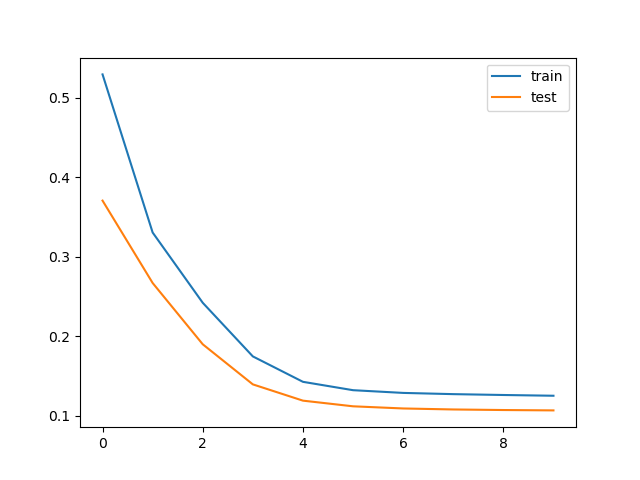

In [18]:
# plot history
pyplot.plot(history.history['loss'], label='train')
pyplot.plot(history.history['val_loss'], label='test')
pyplot.legend()
pyplot.show()

## Evaluate model

In [94]:
from numpy import concatenate
from math import sqrt

from sklearn.metrics import classification_report

In [20]:
model.evaluate(test_X, test_y)

1095/1095 [==============================] - 3s 2ms/step - loss: 0.1068 - accuracy: 0.9737


[0.10678217560052872, 0.9736864566802979]

In [90]:
# make prediction
yhat = model.predict(test_X)
yhat[yhat <= 0.5] = 0
yhat[yhat > 0.5] = 1

In [ ]:
# invest scaling for forecast
inv_yhat = concatenate(
    ( 
        test_X.reshape( test_X.shape[0], test_X.shape[2] ),
        yhat
    ), axis = 1
)
inv_yhat = scaler.inverse_transform(inv_yhat)[:,-1]

In [91]:
# invert scaling for actual
inv_y = concatenate(
    ( 
        test_X.reshape( test_X.shape[0], test_X.shape[2] ),
        test_y
    ), axis = 1
)
inv_y = scaler.inverse_transform(inv_y)[:,-1]

In [97]:
print(classification_report(inv_y, inv_yhat))

              precision    recall  f1-score   support

         0.0       0.99      0.99      0.99     30889
         1.0       0.89      0.89      0.89      4150

    accuracy                           0.97     35039
   macro avg       0.94      0.94      0.94     35039
weighted avg       0.97      0.97      0.97     35039



In [98]:
# calculate RMSE
rmse = sqrt(mean_squared_error(inv_y, inv_yhat))
print('Test RMSE: %.3f' % rmse)

Test RMSE: 0.162


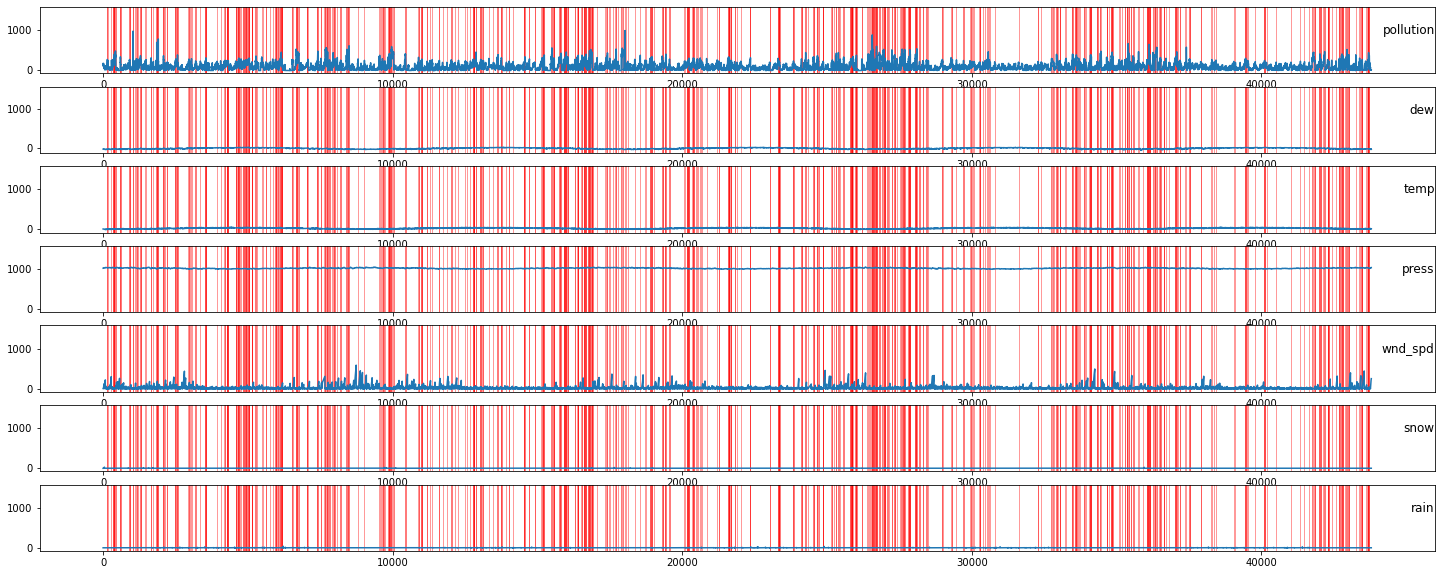

In [103]:
%matplotlib inline
# specify columns to plot
groups = [0, 1, 2, 3, 5, 6, 7]

i = 1
# plot each column
pyplot.figure(figsize=(25,10))
for group in groups:
    ax = pyplot.subplot(len(groups), 1, i)
    pyplot.fill_between(list(range(len(dataset))), 0, 1500, where=dataset.is_polluted, alpha=0.4, color="red", transform=ax.get_xaxis_transform())
    pyplot.plot(dataset.values[:, group])
    pyplot.title(dataset.columns[group], y=0.5, loc='right')
    i += 1
pyplot.show()